In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0, 0.5] * int(D / 2))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
n_iter = 11 * 10**2
lr = 1e-5

In [6]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 19900, Loss: 3.443e+01, Y0: 76.946, Time: 0.20, Learning Rate: 1.000e-05
It: 20000, Loss: 1.256e+01, Y0: 76.954, Time: 19.43, Learning Rate: 1.000e-05
It: 20100, Loss: 1.493e+01, Y0: 76.986, Time: 18.63, Learning Rate: 1.000e-05
It: 20200, Loss: 1.116e+01, Y0: 76.964, Time: 18.83, Learning Rate: 1.000e-05
It: 20300, Loss: 1.117e+01, Y0: 76.961, Time: 18.83, Learning Rate: 1.000e-05
It: 20400, Loss: 1.154e+01, Y0: 76.997, Time: 18.81, Learning Rate: 1.000e-05
It: 20500, Loss: 1.084e+01, Y0: 76.943, Time: 19.10, Learning Rate: 1.000e-05
It: 20600, Loss: 1.201e+01, Y0: 76.999, Time: 19.01, Learning Rate: 1.000e-05
It: 20700, Loss: 1.096e+01, Y0: 76.983, Time: 18.93, Learning Rate: 1.000e-05
It: 20800, Loss: 1.129e+01, Y0: 76.934, Time: 18.89, Learning Rate: 1.000e-05
It: 20900, Loss: 1.669e+01, Y0: 76.992, Time: 18.75, Learning Rate: 1.000e-05
total time: 208.07843828201294 s


In [5]:
model.load_model("models/BlackScholesBarenblattMLMC100D2.pth")

In [7]:
graph = model.iteration, model.training_loss

In [8]:
def figsize(scale, nplots = 1):
    fig_width_pt = 438.17227                        
    inches_per_pt = 1.0/72.27                       
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale    
    fig_height = nplots*fig_width*golden_mean             
    fig_size = [fig_width,fig_height]
    return fig_size

In [9]:
np.random.seed(65)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)
samples = 5

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                    [M, -1, 1])

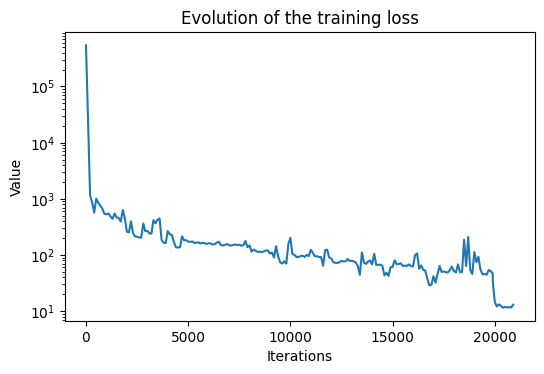

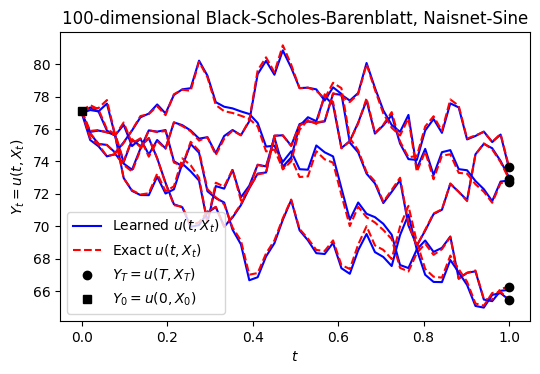

In [10]:
plt.figure(figsize=figsize(1))
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.savefig('Figures/BlackScholesBarenblattMLMC100DLossNoZ.pdf')

plt.figure(figsize=figsize(1))
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.savefig('Figures/BlackScholesBarenblattMLMC100DPredsNoZ.pdf')

plt.show()

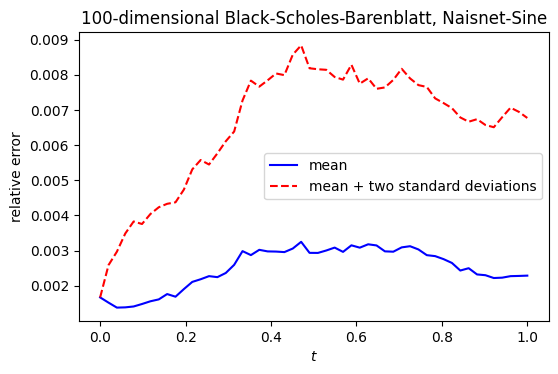

In [11]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)
plt.figure(figsize=figsize(1))
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.savefig('Figures/BlackScholesBarenblattMLMC100DErrorsNoZ.pdf')
plt.show()

In [12]:
model.save_model("models/BlackScholesBarenblattMLMC100DNoZ.pth")